In [1]:
!pip install gymnasium
!pip install -q swig
!pip install gymnasium[box2d]

     -------------------------------------- 925.5/925.5 kB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 14.9/14.9 MB 1.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.9.0 requires tensorflow-estimator<2.10.0,>=2.9.0rc0, but you have tensorflow-estimator 2.3.0 which is incompatible.
torchvision 0.10.0+cu102 requires torch==1.9.0, but you have torch 1.13.1 which is incompatible.


     ------------------------------------ 374.4/374.4 kB 424.0 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pygame-2.1.3-cp38-cp38-win_amd64.whl (10.4 MB)
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp38-cp38-win_amd64.whl size=499525 sha256=42a2a05ddc59714ed9287a48adfb2c9936f4dd51b3c24452c0bcbb786baea4ce
  Stored in directory: c:\users\48722\appdata\local\pip\cache\wheels\8b\95\16\1dc99ff9a3f316ff245fdb5c9086cd13c35dad630809909075
Successfully built box2d-py


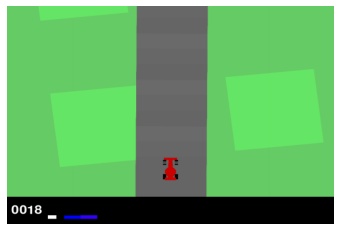

In [1]:
import matplotlib.pyplot as plt
import gymnasium as gym

env = gym.make("CarRacing-v2", render_mode="rgb_array", continuous=False)
env.reset()
for i in range(50):
  env.step(3)

plt.imshow(env.render())
plt.axis("off");

In [2]:
import random
import torch
import numpy as np

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def epsilon_greedy(state, env, net, epsilon=0.0):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else:
    q_values = net(state)
    _, action = torch.max(q_values, dim=1)
    action = int(action.item())
  return action

In [3]:
from collections import deque

class ReplayBuffer:

  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity)

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)

  def sample(self, batch_size):
    return random.sample(self.buffer, batch_size)

In [4]:
from gymnasium.wrappers import RecordVideo, TimeLimit

def create_gym_environment(name, max_episode_steps=1000):
  environment = gym.make(name, render_mode="rgb_array", continuous=False)
  environment = RecordVideo(environment, video_folder=f"./{name}_recored_episodes", episode_trigger=lambda x: x % 5 == 0)

  return environment

In [5]:
from torch.nn import ReLU, Conv2d, ReLU, Module, Flatten, AvgPool2d, Sequential, Linear
import torch.autograd as autograd

class ConvDuelingDQN(Module):

    def __init__(self, hidden_size, input_dim, output_dim):
        super(ConvDuelingDQN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.start_time = time.time()

        self.conv = Sequential(
            AvgPool2d(2),
            Conv2d(3, 16, kernel_size=3, stride=2),
            ReLU(),
            Conv2d(16, 32, kernel_size=3, stride=2),
            ReLU(),
            Flatten()
        )

        self.fc_input_dim = 3872

        self.value_stream = Sequential(
            Linear(self.fc_input_dim, hidden_size),
            ReLU(),
            Linear(hidden_size, 1)
        )

        self.advantage_stream = Sequential(
            Linear(self.fc_input_dim, hidden_size),
            ReLU(),
            Linear(hidden_size, self.output_dim)
        )

    def forward(self, state):
        features = self.conv(state)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean())
        return qvals

In [6]:
import time
from torch.optim import AdamW
from copy import deepcopy
from torch.nn.functional import smooth_l1_loss

class DeepQLearning():

  def __init__(self, env_name, net=None, policy=epsilon_greedy, capacity=20_000,
               batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99,
               loss_fn=smooth_l1_loss, optim=AdamW, eps_start=1.0, eps_end=0.15,
               eps_last_episode=600, samples_per_epoch=1024, sync_rate=25, play_episode_rate=5):
      self.env_name = env_name
      self.env = create_gym_environment(env_name)

      obs_size = self.env.observation_space.shape[0]
      n_actions = self.env.action_space.n

      self.q_net = net if net else ConvDuelingDQN(hidden_size, obs_size, n_actions)

      self.optim = optim(self.q_net.parameters(), lr)
      self.target_q_net = deepcopy(self.q_net)

      self.policy = policy
      self.buffer = ReplayBuffer(capacity=capacity)
      self.loss_fn = loss_fn

      self.gamma = gamma
      self.batch_size = batch_size
      self.eps_start = eps_start
      self.eps_end = eps_end
      self.eps_last_episode = eps_last_episode
      self.sync_rate = sync_rate
      self.samples_per_epoch = samples_per_epoch
      self.lr = lr
      self.play_episode_rate = play_episode_rate

      self.current_epoch = 1
      self.log = []
      self.returns = []
      self.episode_lengths = []
      self.start_time = time.time()

      while len(self.buffer) < self.samples_per_epoch:
        self.play_episode(epsilon=1.0)

  @torch.no_grad()
  def play_episode(self, policy=None, epsilon=0.):
      state = self.env.reset()[0]
      state_v = torch.permute(torch.tensor(state), (2, 0, 1))/255.0
      done = False
      rewards = 0
      epsiode_length = 0

      while not done:
        if policy:
          action = policy(state_v.unsqueeze(0), self.env, self.q_net, epsilon=epsilon)
        else:
          action = self.env.action_space.sample()

        next_state, reward, done1, done2, info = self.env.step(action)
        done = done1 or done2

        rewards += reward
        epsiode_length += 1

        next_state_v = torch.permute(torch.tensor(next_state), (2, 0, 1))/255.0
        action_v = torch.tensor(action)
        reward_v = torch.tensor(reward)
        done_v = torch.tensor(done)
        exp = (state_v, action_v, reward_v, done_v, next_state_v)

        self.buffer.append(exp)
        state = next_state
      return rewards, epsiode_length

  def forward(self, x):
      return self.q_net(x)

  def fit(self, n_epoch):
      for epoch in range(n_epoch):
        loss_total = 0
        for _ in range(self.samples_per_epoch//self.batch_size):

          loss = self.training_step()
          loss_total += loss

        last_return, episode_length  = self.training_epoch_end()

        if last_return is not None:
          self.returns.append(last_return)
          self.episode_lengths.append(episode_length)
          self.log.append([self.current_epoch, last_return, loss_total.item()])

        if self.current_epoch % 25 == 0:
          print(f"Epoch: {self.current_epoch}, mean return: {np.mean(self.returns[-10:]):.2f}, " \
           f"mean episode length: {np.mean(self.episode_lengths[-10:])}, loss: {loss_total:.2f}")


  def training_step(self):
      batch_T = self.buffer.sample(self.batch_size)
      batch = list(map(torch.stack, zip(*batch_T)))

      states, actions, rewards, dones, next_states = batch
      actions = actions.unsqueeze(1)
      rewards = rewards.unsqueeze(1)
      dones = dones.unsqueeze(1)
      state_action_values = self.q_net(states).gather(1, actions)

      next_action_values, _ = self.target_q_net(next_states).max(dim=1, keepdim=True)
      next_action_values[dones] = 0.0

      expected_state_action_values = rewards + self.gamma * next_action_values
      loss = self.loss_fn(state_action_values, expected_state_action_values)

      self.optim.zero_grad()
      loss.backward()
      self.optim.step()
      return loss


  def training_epoch_end(self):
      epsilon = max(self.eps_end, self.eps_start - self.current_epoch / self.eps_last_episode)

      if self.current_epoch % self.play_episode_rate == 0:
        last_return, episode_length = self.play_episode(policy=self.policy, epsilon=epsilon)
      else:
        last_return = None
        episode_length = None

      if self.current_epoch % self.sync_rate == 0:
        self.target_q_net.load_state_dict(self.q_net.state_dict())
      self.current_epoch += 1
      return last_return, episode_length

In [7]:
import shutil

shutil.rmtree("/content/CarRacing-v2_recored_episodes", ignore_errors=True)
q_net = torch.load("/content/CarRacing_qnet")

FileNotFoundError: [Errno 2] No such file or directory: '/content/CarRacing_qnet'

In [8]:
algo = DeepQLearning("CarRacing-v2", None, eps_last_episode=1200, eps_end=0.10, samples_per_epoch=512, batch_size=128)
algo.fit(2000)

c:\users\48722\appdata\local\programs\python\python38\lib\site-packages\gymnasium\wrappers\record_video.py:87: UserWarning: WARN: Overwriting existing videos at C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-0.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-0.mp4
Epoch: 25, mean return: -53.28, mean episode length: 1000.0, loss: 0.15
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-5.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-5.mp4
Epoch: 50, mean return: -52.70, mean episode length: 1000.0, loss: 0.21
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-10.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-10.mp4
Epoch: 75, mean return: -53.48, mean episode length: 1000.0, loss: 0.09
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-15.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-15.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-15.mp4
Epoch: 100, mean return: -57.86, mean episode length: 1000.0, loss: 0.15
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-20.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-20.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-20.mp4
Epoch: 125, mean return: -59.17, mean episode length: 1000.0, loss: 0.21
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-25.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-25.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-25.mp4
Epoch: 150, mean return: -54.61, mean episode length: 1000.0, loss: 0.05
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-30.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-30.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-30.mp4
Epoch: 175, mean return: -52.10, mean episode length: 1000.0, loss: 0.19
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-35.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-35.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-35.mp4
Epoch: 200, mean return: -54.41, mean episode length: 1000.0, loss: 0.09
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-40.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-40.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-40.mp4
Epoch: 225, mean return: -59.02, mean episode length: 1000.0, loss: 0.22
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-45.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-45.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-45.mp4
Epoch: 250, mean return: -60.70, mean episode length: 1000.0, loss: 0.18
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-50.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-50.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-50.mp4
Epoch: 275, mean return: -48.84, mean episode length: 1000.0, loss: 0.03
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-55.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-55.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-55.mp4
Epoch: 300, mean return: -40.85, mean episode length: 1000.0, loss: 0.16
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-60.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-60.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-60.mp4
Epoch: 325, mean return: -48.57, mean episode length: 1000.0, loss: 0.16
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-65.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-65.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-65.mp4
Epoch: 350, mean return: -50.87, mean episode length: 1000.0, loss: 0.12
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-70.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-70.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-70.mp4
Epoch: 375, mean return: -50.69, mean episode length: 1000.0, loss: 0.17
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-75.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-75.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-75.mp4
Epoch: 400, mean return: -55.81, mean episode length: 1000.0, loss: 0.18
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-80.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-80.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-80.mp4
Epoch: 425, mean return: -45.33, mean episode length: 1000.0, loss: 0.28
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-85.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-85.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-85.mp4
Epoch: 450, mean return: -35.77, mean episode length: 1000.0, loss: 0.35
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-90.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-90.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-90.mp4
Epoch: 475, mean return: -40.10, mean episode length: 1000.0, loss: 0.31
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-95.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-95.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-95.mp4
Epoch: 500, mean return: -38.38, mean episode length: 1000.0, loss: 0.26
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-100.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-100.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-100.mp4
Epoch: 525, mean return: -33.63, mean episode length: 1000.0, loss: 0.22
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-105.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-105.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-105.mp4
Epoch: 550, mean return: -35.76, mean episode length: 1000.0, loss: 0.23
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-110.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-110.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-110.mp4
Epoch: 575, mean return: -56.77, mean episode length: 1000.0, loss: 0.18
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-115.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-115.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-115.mp4
Epoch: 600, mean return: -54.07, mean episode length: 1000.0, loss: 0.11
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-120.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-120.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-120.mp4
Epoch: 625, mean return: -26.45, mean episode length: 1000.0, loss: 0.12
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-125.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-125.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-125.mp4
Epoch: 650, mean return: -31.49, mean episode length: 1000.0, loss: 0.21
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-130.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-130.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-130.mp4
Epoch: 675, mean return: -60.58, mean episode length: 1000.0, loss: 0.27
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-135.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-135.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-135.mp4
Epoch: 700, mean return: -66.67, mean episode length: 1000.0, loss: 0.19
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-140.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-140.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-140.mp4
Epoch: 725, mean return: -48.21, mean episode length: 978.7, loss: 0.17
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-145.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-145.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-145.mp4
Epoch: 750, mean return: -45.04, mean episode length: 940.1, loss: 0.24
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-150.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-150.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-150.mp4
Epoch: 775, mean return: -51.44, mean episode length: 961.4, loss: 0.21
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-155.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-155.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-155.mp4
Epoch: 800, mean return: -49.23, mean episode length: 973.6, loss: 0.21
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-160.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-160.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-160.mp4
Epoch: 825, mean return: -60.73, mean episode length: 959.8, loss: 0.14
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-165.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-165.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-165.mp4
Epoch: 850, mean return: -73.51, mean episode length: 940.9, loss: 0.27
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-170.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-170.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-170.mp4
Epoch: 875, mean return: -63.30, mean episode length: 847.8, loss: 0.20
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-175.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-175.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-175.mp4
Epoch: 900, mean return: -75.20, mean episode length: 797.1, loss: 0.25
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-180.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-180.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-180.mp4
Epoch: 925, mean return: -81.80, mean episode length: 694.1, loss: 1.17
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-185.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-185.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-185.mp4
Epoch: 950, mean return: -69.78, mean episode length: 572.4, loss: 1.30
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-190.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-190.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-190.mp4
Epoch: 975, mean return: -80.97, mean episode length: 668.4, loss: 0.34
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-195.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-195.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-195.mp4
Epoch: 1000, mean return: -75.79, mean episode length: 709.2, loss: 3.38
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-200.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-200.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-200.mp4
Epoch: 1025, mean return: -64.85, mean episode length: 563.5, loss: 0.53
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-205.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-205.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-205.mp4
Epoch: 1050, mean return: -64.45, mean episode length: 518.0, loss: 0.56
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-210.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-210.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-210.mp4
Epoch: 1075, mean return: -61.84, mean episode length: 493.4, loss: 1.25
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-215.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-215.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-215.mp4
Epoch: 1100, mean return: -60.57, mean episode length: 475.4, loss: 1.16
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-220.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-220.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-220.mp4
Epoch: 1125, mean return: -47.77, mean episode length: 513.1, loss: 0.36
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-225.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-225.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-225.mp4
Epoch: 1150, mean return: -33.71, mean episode length: 452.8, loss: 2.16
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-230.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-230.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-230.mp4
Epoch: 1175, mean return: -38.88, mean episode length: 406.0, loss: 1.38
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-235.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-235.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-235.mp4
Epoch: 1200, mean return: -42.84, mean episode length: 384.4, loss: 0.66
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-240.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-240.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-240.mp4
Epoch: 1225, mean return: -55.22, mean episode length: 391.3, loss: 3.61
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-245.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-245.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-245.mp4
Epoch: 1250, mean return: -55.47, mean episode length: 399.3, loss: 3.78
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-250.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-250.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-250.mp4
Epoch: 1275, mean return: -45.51, mean episode length: 386.6, loss: 2.31
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-255.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-255.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-255.mp4
Epoch: 1300, mean return: -64.32, mean episode length: 419.7, loss: 0.70
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-260.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-260.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-260.mp4
Epoch: 1325, mean return: -76.17, mean episode length: 442.9, loss: 1.52
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-265.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-265.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-265.mp4
Epoch: 1350, mean return: -73.99, mean episode length: 435.0, loss: 2.20
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-270.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-270.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-270.mp4
Epoch: 1375, mean return: -71.73, mean episode length: 423.5, loss: 2.35
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-275.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-275.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-275.mp4
Epoch: 1400, mean return: -64.27, mean episode length: 430.3, loss: 1.65
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-280.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-280.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-280.mp4
Epoch: 1425, mean return: -40.98, mean episode length: 473.5, loss: 1.30
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-285.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-285.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-285.mp4
Epoch: 1450, mean return: -16.26, mean episode length: 421.6, loss: 2.34
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-290.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-290.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-290.mp4
Epoch: 1475, mean return: -31.01, mean episode length: 424.0, loss: 0.61
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-295.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-295.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-295.mp4
Epoch: 1500, mean return: -67.32, mean episode length: 552.4, loss: 0.59
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-300.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-300.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-300.mp4
Epoch: 1525, mean return: -61.34, mean episode length: 486.1, loss: 0.84
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-305.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-305.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-305.mp4
Epoch: 1550, mean return: -38.91, mean episode length: 380.9, loss: 2.29
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-310.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-310.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-310.mp4
Epoch: 1575, mean return: -44.87, mean episode length: 398.7, loss: 0.85
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-315.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-315.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-315.mp4
Epoch: 1600, mean return: -64.16, mean episode length: 428.3, loss: 1.53
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-320.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-320.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-320.mp4
Epoch: 1625, mean return: -72.36, mean episode length: 429.6, loss: 0.98
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-325.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-325.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-325.mp4
Epoch: 1650, mean return: -49.79, mean episode length: 390.2, loss: 1.24
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-330.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-330.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-330.mp4
Epoch: 1675, mean return: -51.82, mean episode length: 399.2, loss: 2.23
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-335.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-335.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-335.mp4
Epoch: 1700, mean return: -66.24, mean episode length: 591.3, loss: 2.79
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-340.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-340.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-340.mp4
Epoch: 1725, mean return: -50.47, mean episode length: 552.1, loss: 1.39
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-345.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-345.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-345.mp4
Epoch: 1750, mean return: -34.87, mean episode length: 376.1, loss: 1.55
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-350.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-350.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-350.mp4
Epoch: 1775, mean return: -48.99, mean episode length: 417.1, loss: 1.27
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-355.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-355.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-355.mp4
Epoch: 1800, mean return: -62.29, mean episode length: 427.3, loss: 1.65
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-360.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-360.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-360.mp4
Epoch: 1825, mean return: -38.61, mean episode length: 393.4, loss: 0.62
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-365.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-365.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-365.mp4
Epoch: 1850, mean return: -50.71, mean episode length: 456.8, loss: 1.88
Moviepy - Building video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-370.mp4.
Moviepy - Writing video C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-370.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\48722\Desktop\RL\CarRacing-v2_recored_episodes\rl-video-episode-370.mp4


KeyboardInterrupt: 

In [ ]:
torch.save(algo.q_net, "CarRacing_qnet")

In [30]:
text = "It is an short example sentence."

In [38]:
import random
l = text.lower().strip(".").split()
random.shuffle(l)
l[0] = l[0].title()
l[-1] = l[-1] + "."
l = " ".join(l)

text = text + "\n" + l
print(text)

It is an short example sentence.
Is short sentence example an it.
Sentence example is sentence. an short short is an it example it.
An it. sentence. short an sentence. it short is example is example it example an an is example short sentence it short sentence is.


In [53]:
f = open("file.txt", "w")
f.write(text)
f.close()

In [54]:
f = open("file.txt")

In [55]:
f.read()

'It is an short example sentence.\nIs short sentence example an it.\nSentence example is sentence. an short short is an it example it.\nAn it. sentence. short an sentence. it short is example is example it example an an is example short sentence it short sentence is.'

In [56]:
from itertools import islice
f = open("file.txt", "r")
for line in f:
    print(line)

It is an short example sentence.

Is short sentence example an it.

Sentence example is sentence. an short short is an it example it.

An it. sentence. short an sentence. it short is example is example it example an an is example short sentence it short sentence is.


In [57]:
from shutil import copyfile
copyfile('file.txt', 'abc.py')

'abc.py'

In [60]:
f = open("abc.py", "r")
f.read()

'It is an short example sentence.\nIs short sentence example an it.\nSentence example is sentence. an short short is an it example it.\nAn it. sentence. short an sentence. it short is example is example it example an an is example short sentence it short sentence is.'

In [61]:
f.closed

False

In [62]:
f.close

<function TextIOWrapper.close()>

In [63]:
f.close()

In [64]:
f.closed

True

In [66]:
from itertools import islice
nums = [12,45,23,67,78,90,45,32,100,76,38,62,73,29,83]

list(islice(nums, 3))

[12, 45, 23]

In [70]:
iter((3,2,1), 1)

TypeError: iter(v, w): v must be callable

In [75]:
import functools
functools.cache

AttributeError: module 'functools' has no attribute 'cache'

In [77]:
import time
from functools import lru_cache

@lru_cache
def time_expensive_function(a, b):
    time.sleep(5)
    return a + b

In [81]:
start = time.time()
time_expensive_function(2, 3)
print(start - time.time())

-5.001824378967285
